# Fine-tuning with a specific loss function

When fine-tuning, the model trains on your dataset to tailor its predictions to your particular scenario. As such, it is possible to specify the loss function used during fine-tuning.

Specifically, you can choose from:
- `"default"` - a proprietary loss function that is robust to outliers
- `"mae"` - mean absolute error
- `"mse"` - mean squared error
- `"rmse"` - root mean squared error
- `"mape"` - mean absolute percentage error
- `"smape"` - symmetric mean absolute percentage error

In [ ]:
#| hide
from nixtlats.utils import colab_badge

In [ ]:
#| hide
from dotenv import load_dotenv

In [ ]:
#| hide
load_dotenv()

True

In [ ]:
import pandas as pd
from nixtlats import TimeGPT

In [ ]:
timegpt = TimeGPT(
    # defaults to os.environ.get("TIMEGPT_TOKEN")
    token = 'my_token_provided_by_nixtla'
)

In [ ]:
#| hide
timegpt = TimeGPT()

Let's fine-tune the model on a dataset using the mean absolute error (MAE).

For that, we simply pass the appropriate string representing the loss function to the `finetune_loss` parameter of the `forecast` method.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/air_passengers.csv')
df.head()

,timestamp,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [ ]:
timegpt_fcst_finetune_mae_df = timegpt.forecast(
    df=df, 
    h=12, 
    finetune_steps=10,
    finetune_loss='mae',   # Set your desired loss function
    time_col='timestamp', 
    target_col='value',
)

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Inferred freq: MS
INFO:nixtlats.timegpt:Calling Forecast Endpoint...


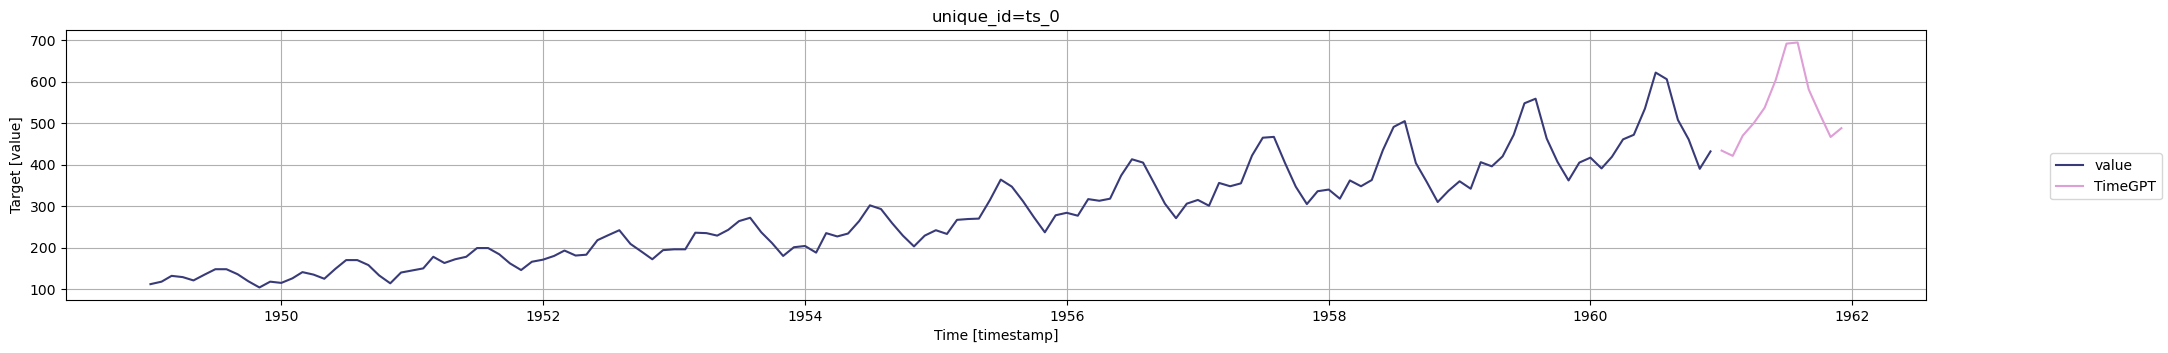

In [ ]:
timegpt.plot(
    df, timegpt_fcst_finetune_mae_df, 
    time_col='timestamp', target_col='value',
)

Now, depending on your data, you will use a specific error metric to accurately evaluate your forecasting model's performance.

Below is a non-exhaustive guide on which metric to use depdending on your use case.

**Mean absolute error (MAE)**
- Robust to outliers
- Easy to understand
- You care equally about all error sizes
- Same units as your data

**Mean squared error (MSE)**
- You want to penalize large errors more than small ones
- Sensitive to outliers
- Used when large errors must be avoided
- *Not* the same units as your data

**Root mean squared error (RMSE)**
- Brings the MSE back to original units of data
- Penalizes large errors more than small ones

**Mean absolute percentage error (MAPE)**
- Easy to understand for non-technical stakeholders
- Expressed as a percentage
- Heavier penalty on positive errors over negative errors
- To be avoided if your data has values close to 0 or equal to 0

**Symmmetric mean absolute percentage error (sMAPE)**
- Fixes bias of MAPE
- Equally senstitive to over and under forecasting
- To be avoided if your data has values close to 0 or equal to 0

With TimeGPT, you can choose your loss function during fine-tuning as to maximize the model's performance metric for your particular use case. 

Let's run a small experiment to see how each loss function improves their associated metric when compared to the default setting.

In [ ]:
train = df[:-36]
test = df[-36:]

In [ ]:
losses = ['default', 'mae', 'mse', 'rmse', 'mape', 'smape']

for loss in losses:
    preds_df = timegpt.forecast(
    df=train, 
    h=36, 
    finetune_steps=10,
    finetune_loss=loss,
    time_col='timestamp', 
    target_col='value')

    preds = preds_df['TimeGPT'].values

    test.loc[:,f'TimeGPT_{loss}'] = preds

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Inferred freq: MS
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Inferred freq: MS
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Inferred freq: MS
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Inferred freq: MS
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Inferred freq: MS
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing d

In [ ]:
#| hide
test.head()

,timestamp,value,TimeGPT_default,TimeGPT_mae,TimeGPT_mse,TimeGPT_rmse,TimeGPT_mape,TimeGPT_smape
108,1958-01-01,340,347.241211,341.780579,347.600616,347.059113,356.154938,341.958679
109,1958-02-01,318,345.839355,343.387573,346.399963,345.678314,354.163422,343.929657
110,1958-03-01,362,394.854248,390.733337,395.436646,394.636627,396.496155,392.543640
111,1958-04-01,348,403.989929,400.326843,404.369598,403.498901,396.927185,402.459625
112,1958-05-01,363,421.058411,418.293030,422.122223,421.541443,410.335663,422.161255


Great! We have predictions from TimeGPT using all the different loss functions. We can evaluate the performance using their associated metric and measure the improvement.

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error

def symmetric_mean_absolute_error(y, y_hat):
    return 100/len(y) * np.sum(2 * np.abs(y_hat - y) / (np.abs(y) + np.abs(y_hat)))

loss_default_mae = mean_absolute_error(test['value'], test['TimeGPT_default'])
loss_default_mse = mean_squared_error(test['value'], test['TimeGPT_default'])
loss_default_rmse = root_mean_squared_error(test['value'], test['TimeGPT_default'])
loss_default_mape = mean_absolute_percentage_error(test['value'], test['TimeGPT_default'])
loss_default_smape = symmetric_mean_absolute_error(test['value'], test['TimeGPT_default'])

loss_mae_mae = mean_absolute_error(test['value'], test['TimeGPT_mae'])
loss_mse_mse = mean_squared_error(test['value'], test['TimeGPT_mse'])
loss_rmse_rmse = root_mean_squared_error(test['value'], test['TimeGPT_rmse'])
loss_mape_mape = mean_absolute_percentage_error(test['value'], test['TimeGPT_mape'])
loss_smape_smape = symmetric_mean_absolute_error(test['value'], test['TimeGPT_smape'])

data = {
    'mae': [round((loss_default_mae - loss_mae_mae) / loss_default_mae * 100, 2)],
    'mse': [round((loss_default_mse - loss_mse_mse) / loss_default_mse * 100, 2)],
    'rmse': [round((loss_default_rmse - loss_rmse_rmse) / loss_default_rmse * 100, 2)],
    'mape': [round((loss_default_mape - loss_mape_mape) / loss_default_mape * 100, 2)],
    'smape': [round((loss_default_smape - loss_smape_smape) / loss_default_smape * 100, 2)]
}

results_df = pd.DataFrame(data=data)
results_df.index = ['Metric improvement (%)']

results_df


,mae,mse,rmse,mape,smape
Metric improvement (%),9.69,0.09,0.53,30.98,7.32


From the table above, we can see that using a specific loss function during fine-tuning will improve its associated error metric when compared to the default loss function.

In this exmaple, using the MAE as the loss function improves the metric by 9.7% when compared to using the default loss function.

That way, depending on your use case and performance metric, you can use the appropriate loss function to maximize the accuracy of the forecasts.